<a href="https://colab.research.google.com/github/astrohayley/data-driven-galaxy-evolution-tutorials/blob/main/Large_scale_galaxy_formation_simulations_and_machine_learning_approaches_Part2_Gaussian_process_regression_for_emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-1/Large_scale_galaxy_formation_simulations_and_machine_learning_approaches_(Part_2)_Gaussian_process_regression_for_emulation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Guassian process regression for emulation

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-1/Large_scale_galaxy_formation_simulations_and_machine_learning_approaches_(Part_2)_Gaussian_process_regression_for_emulation.ipynb)


* What's emulation?

[Emulation (or surrogate modeling)](https://en.wikipedia.org/wiki/Surrogate_model) is an engineering method to simplify an outcome of an expensive function using an approximate model. Large astrophysical simulations usually require lots of computational power to compute. In a situation where we need millions of simulation evaluations, for example, performing Bayesian inference using astrophysical simulations, it will be impractical to directly use simulations for performing inference. An emulator (or metamodel) approximating the actual simulation outcomes but computationally cheaper to evaluate is designed to solve the above situation.

* Why Gaussian process?

Gaussian process (GP) is not the only model for emulators. Any suitable fitting model should work (e.g., neural net).

The unique thing about [GP in emulation](https://en.wikipedia.org/wiki/Gaussian_process_emulator) is that the Bayesian community has been using GP to analyze computer simulations for decades. The benefit of GP is that it turns the problem of learning about a simulation code into a Bayesian problem. Early cosmological emulation literature, [Heitmann (2006)](https://arxiv.org/abs/astro-ph/0606154) and [Heitmann (2009)](https://arxiv.org/abs/0902.0429), also used GPs as emulators.


* What are the key points about learning a GP?

A GP can be defined by its first two moments, mean and covariance functions (similar to a Gaussian distribution can be defined by its mean and variance). Usually, a zero mean function is used, so the only thing left to optimize is the covariance function.

GP library usually comes with a collection of covariance function kernels, and each of the kernels represents different functional behaviors (check [Kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)). If you can't find a kernel that matches your problem, you can also build data-driven kernels (similar to [Garnett (2016)](https://arxiv.org/abs/1605.04460) [Ho (2020)](https://arxiv.org/abs/2003.11036)).


* Why use Tensorflow?

No special reason. Any GP library (e.g., [GPy](https://gpy.readthedocs.io/en/deploy/), [GPML Matlab](http://gaussianprocess.org/gpml/code/matlab/doc/)) should work fine.

One benefit of using Tensorflow here is that it is built-in in Colab since Tensorflow is a deep learning library used by Google. And they want people to use their product.

We will use [Tensorflow probability](https://github.com/tensorflow/probability) in this tutorial. I think TFP is quite fun to use (it's slightly different from other GP libraries: the codes look chunkier than other libraries but in a fun way.)




## About this tutorial

I encourage reading Tensorflow probability's [GP tutorial](https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP
). The codes below are modified from TFP's official tutorial to fit our GP emulation problem.

The emulation problem we have here is to emulate this function:

$$
\mathrm{Cosmological\,and\,Astrophysical\, Parameters} → (\mathrm{simulation\,code}) → \mathrm{Ly\alpha \, flux \, power \, spectrum}.
$$

Say cosmological parameters are from set $\mathcal{X}$. The Ly$\alpha$ flux power spectrum is denoted as $P_F(k)$, which is a vector $P_F(k) \in \mathbb{R}^{N_\mathrm{outputs}}$. $N_\mathrm{outputs}$ denotes how many $k$ bins in the flux power spectrum.

The approach we took here is to directly emulate the flux power spectrum from cosmological parameters using a GP:

$$
\mathcal{X} → (f: \mathrm{emulator}) → P_F(k).
$$

Function $f$ is the emulator we want to learn using a GP:

$$
f \sim \textsf{GaussianProcess}\left(
 \text{mean_fn}=\mu(x),
 \text{covariance_fn}=k(x, x')\right).
$$

To train a GP, we first need a training set $\{X_1, \ldots, X_{N_\mathrm{examples}}\} \subset \mathcal{X}$, which is a finite subset of the input cosmological parameter space.

Here $N_\mathrm{examples}$ means the number of simulations we will be using for training.

## Convention of Tensorflow Probability

*  number_examples : number of training simulations
*  number_features : number of dimensions of the parameters/features you have in input space
*  number_outputs : number of bins you have in output space




In [15]:
import time

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# tensorflow should have already installed in the colab env
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

# below are the conventions used in the TFP official website
tfb = tfp.bijectors
tfd = tfp.distributions     # to access all kinds of probability distributions
tfk = tfp.math.psd_kernels  # to access the kernels used in Gaussian process
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


## Prepare Lyman alpha flux power spectrum data

* Where did you get the data?

We will use Lya flux power spectra from 40 Astrid simulations with 30 Mpc/h box and $256^3$ particles at redshift z = 2.

| Number of particles | Box size | Redshift |
| --- | --- | --- |
| $256^3$ | $30 \, \mathrm{Mpc}/h$ | $2$ |

We will use 30 of the simulations for training, and 10 of them for testing the GP prediction error.

40 Astrid simulations are spanning in 9 dimensional parameters:

| Parameter | Prior | Examplanation |
| --- | --- | --- |
|ns | [0.8, 0.995] | Slope of power spectrum |
| Ap | [1.2e-09, 2.6e-09] | Amplitude of power spectrum at 8/2pi Mpc scales (see 1812.04654) |
| herei | [3.5, 4.1] | Redshift at which helium reionization starts. 4.0 is default, we use a linear history with 3.5-4.5 |
| heref | [2.6, 3.2] | Redshift at which helium reionization finishes. 2.8 is default. Thermal history suggests late, HeII Lyman alpha suggests earlier.|
| alphaq |[1.6, 2.5] | Quasar spectral index. Controls IGM temperature.|
| hub | [0.65, 0.75] | Hubble constant (also changes omega_M) |
| omegam h^2 | [0.14, 0.146] | We fix omega_m h^2 = 0.143+-0.001 (Planck 2018 best-fit) and vary omega_m and h^2 to match it. h^2 itself has little effect on the forest. |
| hireionz |[6.5,8] | Mid-point of HI reionization |
| bhfeedback | [0.03, 0.07] | Black hole feedback parameter |


* What's Lya flux power spectrum?

Lya flux Power spectrum, $P_F(k)$, is the Fourier Transform of the correlation function of neutral hydrogen in the Universe. 



In [3]:
!wget -q -nc -O train_input_fidelity_0.txt https://raw.githubusercontent.com/jibanCat/multi_fidelity_tensorflow/main/data/MF-40-6/Lyaflux_40_res256box30_6_res512box30_2/train_input_fidelity_0.txt
!wget -q -nc -O train_output_fidelity_0.txt https://raw.githubusercontent.com/jibanCat/multi_fidelity_tensorflow/main/data/MF-40-6/Lyaflux_40_res256box30_6_res512box30_2/train_output_fidelity_0.txt

In [16]:
# the k bins for the Lya flux power
#   shape: [number of outputs, ]
kf = np.array([
        0.00225214, 0.00450427, 0.00675641, 0.00900854, 0.01126068,
        0.01351281, 0.01576495, 0.01801709, 0.02026922, 0.02252136,
        0.02477349, 0.02702563, 0.02927776, 0.0315299 , 0.03378203,
        0.03603417, 0.03828631, 0.04053844, 0.04279058, 0.04504271,
        0.04729485, 0.04954698, 0.05179912, 0.05405126, 0.05630339
  ]
) # unit: [s/km]

# X is the input cosmological+astrophysical parameters, in 9-dimension
#   shape: [number of examples, number of features]
X = np.loadtxt("train_input_fidelity_0.txt")

param_dict = {
    "ns": 0,
    "Ap": 1,
    "herei": 2,
    "heref": 3,
    "alphaq": 4,
    "hub": 5,
    "omegamh2": 6,
    "hireionz": 7,
    "bhfeedback": 8
 }

# lower and upper bounds (prior volume) of the cosmological parameters
# this will be used to normalize the input parameters
#   shape: [number of examples, 2]
param_limits = np.array([
  [8.00e-01, 9.95e-01],
  [1.20e-09, 2.60e-09],
  [3.50e+00, 4.10e+00],
  [2.60e+00, 3.20e+00],
  [1.60e+00, 2.50e+00],
  [6.50e-01, 7.50e-01],
  [1.40e-01, 1.46e-01],
  [6.50e+00, 8.00e+00],
  [3.00e-02, 7.00e-02],
])

# Y is the power spectrum, P(k),
#   shape: [number of examples, number of outputs]
Y = np.loadtxt("train_output_fidelity_0.txt")


Let's see what the input (X) and output (Y) look like:

In [17]:
print("Shape of cosmology input, X:", X.shape)
print("Shape of P_F(k) output, Y:", Y.shape)

Shape of cosmology input, X: (40, 9)
Shape of P_F(k) output, Y: (40, 25)


Text(0, 0.5, 'Ap')

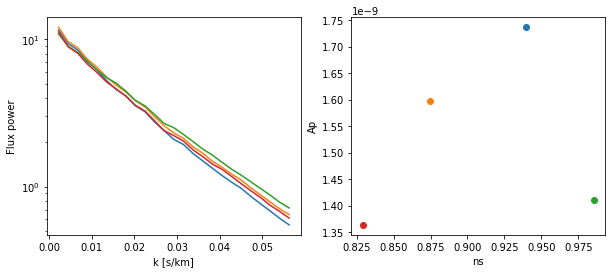

In [18]:
# preview the first 4 simulations
# also plot the input parameters in ith and jth dimension

#### Changable: Choice of two-dim projection of parameters ####
param_i = 0  # choose 0 ~ 8
param_j = 1  # choose 0 ~ 8
###############################################################

param_names = list(param_dict.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for k in range(4):
  ax[0].semilogy(
      kf, Y[k, :],
      color="C{}".format(k)
  )

  # view the input X with the corresponding colors
  ax[1].plot(
      X[k, param_i], X[k, param_j],
      ls="",
      marker="o",
      color="C{}".format(k)
  )


ax[0].set_xlabel("k [s/km]")
ax[0].set_ylabel("Flux power")

ax[1].set_xlabel(param_names[param_i])
ax[1].set_ylabel(param_names[param_j])

Left panel: $P_F(k)$ from four different simulations. Right panel: four different input cosmologies (projected on two-dimension) of the simulations corresponding to the left panel.

Below we will normalize both the input cosmologies, X, and the output, Y.

* X will be normalized to $\mathcal{X} \in [0, 1]$
* Y will be normalized by the median spectrum.
 * $P_F(k) ← P_F(k) / \mathrm{Median}(P_F(k)) - 1$.
 * This way, we can ensure the output Y is close to the zero mean.

In [19]:
#@title Normalize input and output
def input_normalize(
    params: np.ndarray, param_limits: np.ndarray
) -> np.ndarray:
    """
    Map a parameter vector to the unit cube from the original dimensions
    of the space.

    Parameters:
    ----
    params: (n_examples, n_features) parameter vectors.
    :param param_limits: (n_features, 2) the upper and lower bounds of the priors.
    
    Return:
    ----
    params_cube, (n_examples, n_features) parameter vectors 
        in a unit cube, [0,1].
    """
    params_cube = (
        (params - param_limits[:,0]) / (param_limits[:,1] - param_limits[:,0])
    )

    # make sure it is in [0, 1]
    assert np.all((params_cube >= 0)*(params_cube <= 1))

    return params_cube


In [20]:
# Normalize input to a [0 - 1] Latin Hypercube
# This is to avoid the lengthscale & amplitude prior
# to hard to define
X = input_normalize(X, param_limits=param_limits)

In [21]:
# preview what the normalization looks like
X[:2]

array([[0.71666667, 0.38333333, 0.21666667, 0.78333333, 0.41666667,
        0.91666667, 0.81666667, 0.51666667, 0.11666667],
       [0.38333333, 0.28333333, 0.11666667, 0.25      , 0.15      ,
        0.38333333, 0.88333333, 0.98333333, 0.95      ]])

In [22]:
# Normalize the flux vectors by the median Lya flux power spectrum.
# This ensures that the GP prior (zero mean) is close to true.
medind = np.argsort(np.mean(Y, axis=1))[np.shape(Y)[0]//2]
scalefactors = Y[medind, :] # median Lya flux power spectrum

# Y <- (Y / median Lya power spectrum) - 1
Y = Y / scalefactors - 1.

# The transpose here is to fullfill the convention of tensorflow, 
# which wants Y in dimension of: (num of outputs, num of examples)
Y = Y.T

In [23]:
# preview what the normalization looks like
Y[:, 0]

array([-0.0913938 , -0.06003037, -0.05893175, -0.03794685, -0.05758803,
       -0.05380129, -0.03388564, -0.03150319, -0.04942044, -0.04441282,
       -0.04761579, -0.05871087, -0.04826128, -0.03158352, -0.05546396,
       -0.0734853 , -0.07148575, -0.06974122, -0.06907337, -0.09686361,
       -0.08479742, -0.0920841 , -0.0869163 , -0.09801145, -0.09846184])

Do a simple test-train split here: use 30 simulations for training and 10 for testing.

In [24]:
num_training = 30
num_testing = 10

assert (num_training + num_testing) <= X.shape[0]

# keep some samples for testing
X_test = X[:num_testing, :]
Y_test = Y[:, :num_testing]

# Only use part of them for training
X = X[num_testing:(num_testing + num_training), :]
Y = Y[:, num_testing:(num_testing + num_training)]

print("Training input X:", X.shape)
print("Training output Y:", Y.shape)
print("Testing input X:", X_test.shape)
print("Testing output Y:", Y_test.shape)


Training input X: (30, 9)
Training output Y: (25, 30)
Testing input X: (10, 9)
Testing output Y: (25, 10)


In [25]:
# the convention of tensorflow:
#  number_examples : number of training simulations
#  number_features : number of parameters you have in input space
#  number_outputs  : number of bins you have in output space
num_examples, num_features = X.shape
num_outputs, num_examples  = Y.shape

Finally, let's see what the normalized X and Y look like:

Text(0, 0.5, 'Ap')

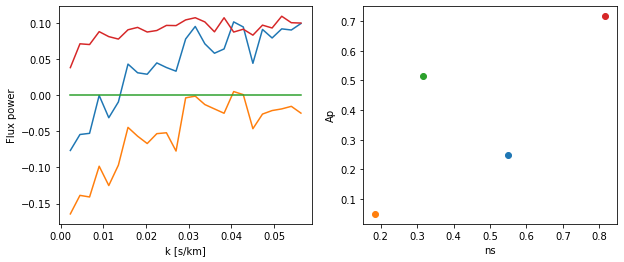

In [26]:
# preview the first 4 simulations
# also plot the input parameters in ith and jth dimension

#### Changable: Choice of two-dim projection of parameters ####
param_i = 0  # choose 0 ~ 8
param_j = 1  # choose 0 ~ 8
###############################################################

param_names = list(param_dict.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for k in range(4):
  ax[0].plot(
      kf, Y[:, k],
      color="C{}".format(k)
  )

  # view the input X with the corresponding colors
  ax[1].plot(
      X[k, param_i], X[k, param_j],
      ls="",
      marker="o",
      color="C{}".format(k)
  )


ax[0].set_xlabel("k [s/km]")
ax[0].set_ylabel("Flux power")

ax[1].set_xlabel(param_names[param_i])
ax[1].set_ylabel(param_names[param_j])

## Build your GP with TensorFlow

We want our GP to have different hyperparameters for different feature dimensions. There are 9 dimensions in the input space, and we want our GP's covariance function behaves differently in a different dimension.

Assigning different hyperparameters for each dimension is also called Automatic Relevance Determination (ARD) in the GP community. If we use a standard Exponiated Quadratic (also called Radial Basis or Squared Exponential) kernel, ARD will assign one lengthscale per feature dimension (9 lengthscales in our case).

ARD can be applied through [`FeatureScaled`](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/FeatureScaled) kernel in Tensflow probability.


```python
tfp.math.psd_kernels.FeatureScaled(
 kernel,
 scale_diag=None,
 inverse_scale_diag=None,
 validate_args=False,
 name='FeatureScaled'
)
```

> Given a kernel `K` and `scale_diag` and inputs `x` and `x'`, this kernel first rescales the input by computing `x / scale_diag` and `x' / scale_diag`, and passing this to `K`.



### Choose your kernels


As mentioned before, the outcomes of the simulation code are assumed to be sampled from an emulator, $f$:

$$
f \sim \textsf{GaussianProcess}\left(0, \text{covariance_fn}=k(x, x')\right).
$$

The only thing left to be learned from the training set is the covariance function, $k(x, x')$.

Here we choose the most common GP kernel, ExponentiatedQuadratic (also called Radial Basis or Gaussian kernel) covariance kernel:

$$
k(x, x') = \sigma^2 \exp \left( \frac{\|x - x'\|^2}{\lambda^2} \right),
$$

* $\sigma^2$: the variance, it is called **amplitude** in TFP.
* $\lambda$: the lengthscale.



In [27]:
def build_gp(amplitude, length_scales):
    """
    Defines the conditional dist. of GP outputs, given kernel parameters.

    Parameters:
    ----
    amplitude: the variance of the ExponentiatedQuadratic kernel.
    length_scales: the lengthscales of the ExponentiatedQuadratic kernel.
      Assumed to be the same length as num_features.

    Return:
    ----
    tfd.GaussianProcess : GP prior
    """

    # choose your kernel. Not define lengthscale, fall back to lengthscale = 1
    se_kernel = tfk.ExponentiatedQuadratic(
        amplitude 
    )
    # this is our ARD kernel, with 1 lengthscale per feature dim.
    # we use scale_diag to represent the lengthscales.
    kernel = tfk.FeatureScaled(
        se_kernel,
        scale_diag = length_scales,
      )
    # Exercise: why applying FeatureScaled makes the ExponentiatedQuadratic to be ARD?

    # return the GP prior.
    return tfd.GaussianProcess(
        kernel=kernel,   # kernel: ExponentiatedQuadratic with ARD
        index_points=X,  # this is your training input cosmology
        # I remove the observation noise since this is an emulation problem,
        # assuming the code output is deterministic.
    )



Let's have another function to see the outcomes of this GP kernel.

In [28]:
#@title Sample from GP prior: choices of kernel hyperparameters
def _view_gp_prior(
      amplitude: float,
      length_scales: np.ndarray,
      index_points: np.ndarray,
      num_samples: int = 50
      ) -> np.ndarray:
    """
    View GP prior

    Parameters:
    ----
    amplitude: the variance of the ExponentiatedQuadratic kernel.
    length_scales: the lengthscales of the ExponentiatedQuadratic kernel. Assume
      to be the same length as num_features.

    Return:
    ----
    tfd.GaussianProcessRegressionModel : GP prior "predictions"
    """

    # choose your kernel. Not define lengthscale, fall back to lengthscale = 1
    se_kernel = tfk.ExponentiatedQuadratic(
        amplitude 
    )
    # this is our ARD kernel, with 1 lengthscale per feature dim.
    # we use scale_diag to represent the lengthscales.
    kernel = tfk.FeatureScaled(
        se_kernel,
        scale_diag = length_scales,
      )

    # return the GP prior.
    gp_prior = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=index_points,
        predictive_noise_variance=0.,
    )

    return gp_prior.sample(num_samples)


For simplicity, we only view the variation in the 0th parameter dimension.

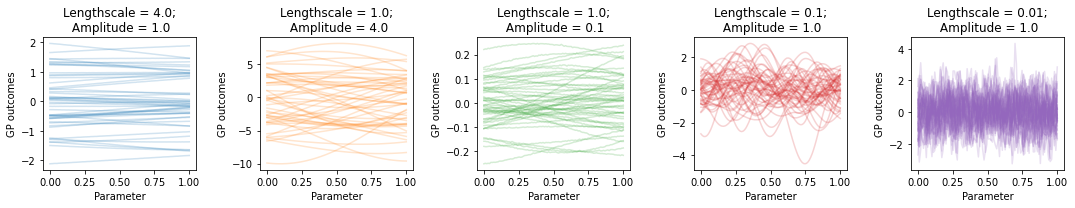

In [29]:
# set some arbitrary lengthscales and amplitude, and preview the GP prior

#### Changable: Choose 5 arbitrary hyperparameters ####
ls_list  = [4.0, 1.0, 1.0, 0.1, 0.01]   # choose 5 different lengthscales to plot
amp_list = [1.0, 4.0, 0.1, 1.0, 1.0]    # choose 5 different amplitudes   to plot
#######################################################

# create a one-parameter-variation set
_index_points = np.ones([100, 9]) * 0.5      # central location
_index_points[:, 0] = np.linspace(0, 1, 100) # 1-parameter variation

# Plot them all in one fig
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for j, (ls, amp) in enumerate(zip(ls_list, amp_list)):
  ls  = np.ones([num_features]) * ls
  amp = np.float64(amp)

  # sample the GP prior from index points. Here we sample 50 samples from the GP.
  prior_samples = _view_gp_prior(amp, ls, _index_points, num_samples=50)

  for i in range(50):
    ax[j].plot(_index_points[:, 0], prior_samples[i, :], color="C{}".format(j), alpha=0.2)

  ax[j].set_title("Lengthscale = {};\n Amplitude = {}".format(ls[0], amp))
  ax[j].set_ylabel("GP outcomes")
  ax[j].set_xlabel("Parameter")

fig.tight_layout()

As shown above, the lengthscale parameter controls the smoothness of the function variation. Larger lengthscale, the function outcomes become smoother.

### Optimize your kernel: Maximum likelihood estimation method

We know different lengthscales and amplitudes corresponding to different functional outcomes. But how to determine them?

We will optimize lengthscales and amplitude using the maximum likelihood method. The likelihood here comes from the fact a finite subset of a GP is a multivariate normal distribution. We can therefore write the likelihood of the training set as:

$$
p(\boldsymbol{\mathrm{Y}} \mid \boldsymbol{\mathrm{X}}, \mu = 0, K(x, x'; \lambda, \sigma^2)) = 
\textsf{MultivariateNormal}( \boldsymbol{\mathrm{Y}}; 
 \mu =
 \begin{bmatrix}
 \mu(x_1) = 0 \\
 \vdots \\
 \mu(x_{N}) = 0
 \end{bmatrix} \:,\:
 \boldsymbol{\mathrm{K}} =
 \begin{bmatrix}
 k(x_1, x_1) & \cdots & k(x_1, x_{N}) \\
 \vdots & \ddots & \vdots \\
 k(x_N, x_1) & \cdots & k(x_N, x_{N}) \\
 \end{bmatrix}
)
$$

Here $N$ is $N_\mathrm{examples}$.

The probability density of multivariate normal distribution is:
$$
\textsf{MultivariateNormal}(\boldsymbol{\mathrm{f}}; \boldsymbol{\mathrm{\mu}}, \boldsymbol{\mathrm{K}}) = \frac{1}{\sqrt{(2\pi )^d \det \boldsymbol{\mathrm{K}}}} \exp ( -\frac{1}{2} (\boldsymbol{\mathrm{f}} - \boldsymbol {\mu })^\top \boldsymbol {\mathrm{K}}^{-1}(\boldsymbol{\mathrm{f}} - \boldsymbol {\mu }) )
$$

We can get the optimal lengthscales and amplitude by optimizing this multivariate normal likelihood using our training set.

#### Priors for hyperparameters

Here we set the log-normal priors for the lengthscales and amplitude. Using priors ensures the optimization won't get crazy and get to too extreme values.

$$
\textsf{lengthscale}_j \sim \textsf{LogNormal}(\mu_j, \sigma_j), j = 1, \dots, N_{features}\\
\textsf{amplitude} \sim \textsf{LogNormal}(\mu, \sigma)
$$

In [30]:
# joint distribution = priors + GP likelihood
# Note that here we only have "1" amplitude and "num_features" lengthscales, and
#   these hyerparameters are shared between "num_outputs" bins.
gp_joint_model = tfd.JointDistributionNamed({
    'amplitude':
        tfd.LogNormal(
            loc=np.float64(0.),
            scale=np.float64(1.0),
    ),
    # Why Independent?
    #   -> TFP automaticall interpret the 0th dim as the batch dimension.
    #.     we actually want the batch_dim to be num_outputs (the dimension of
    #.     k bins). So here we reinterpret the dimension of (num_features, ) 
    #.     as event dimension instead of batch dimension.
    'length_scales':
      tfd.Independent(
        tfd.LogNormal(
            loc=np.ones([num_features], dtype=np.float64) * 0.,
            scale=np.ones([num_features], dtype=np.float64)
        ), reinterpreted_batch_ndims=1
      ),
    'observations': build_gp,
})

In [31]:
# This is the log-likelihood function used for kernel optimization.
def target_log_prob(
    amplitude,
    length_scale,
  ):
  lp =  gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scales': length_scale,
      'observations': Y,
  })

  # Here we take the joint likelihood for the outputs from different k bins.
  # Note that we take the batch dimension to be num_outputs, that is, 
  # we will have num_outputs likelihoods per GP.
  joint_log_likelihood = tf.reduce_sum(lp)

  return joint_log_likelihood

#### Optimization setup

Here we minimize the negative log-likelihood using [Adam](https://arxiv.org/abs/1412.6980), an optimizer frequently used in optimizing deep neural nets.

[jwuphysics](https://jwuphysics.github.io/) will talk more about the optimizers and scheduler in [Thursday's: Introduction to Convolutional Neural Networks tutorial](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-1/Introduction%20to%20convolutional%20neural%20networks.ipynb). Stay tuned!

In [32]:
# Here we constrain the hyperparameters to be positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

# Below defined the trainable kernel hyperparameters
amplitude_var = tfp.util.TransformedVariable(
    initial_value=np.float64(1.0),
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64
  )

length_scale_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_features]),
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64,
)

trainable_variables = [
    v.trainable_variables[0] for v in 
    [
        amplitude_var,
        length_scale_var,
    ]
]

In [33]:
#### Changable: Optimizer options ###################
num_iters = 3000                                    # these two numbers need to tune for different problems
optimizer = tf.optimizers.Adam(learning_rate=5e-3)  # these two numbers need to tune for different problems
#####################################################


# TFP: Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Negative log likelihood history:
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained hyperparameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scales: {}'.format(length_scale_var._value().numpy()))

Trained hyperparameters:
amplitude: 0.06423983251936281
length_scales: [1.6166071  0.74178402 2.36258388 1.94446681 2.16694553 0.75488384
 1.72759597 2.13639852 2.64644265]


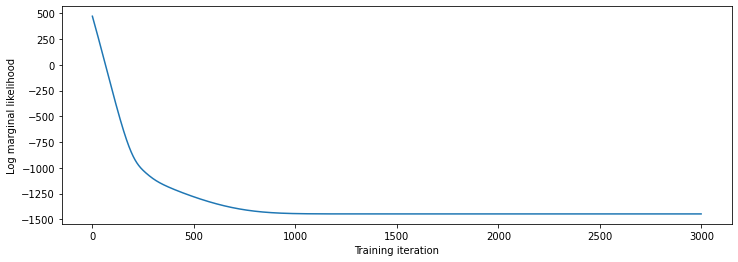

In [34]:
# Negative log likelihood history
plt.figure(figsize=(12, 4))
plt.plot(lls_ )
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

Generally speaking:
* Larger learning rate $→$ faster the loss goes down (but if the learning rate is too large, there's a possibility it won't go to the local minimum).
* Smaller learning rate $→$ usually require more training iterations

Details please find [jwuphysics](https://jwuphysics.github.io/)'s [Introduction to Convolutional Neural Networks tutorial](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-1/Introduction%20to%20convolutional%20neural%20networks.ipynb). Stay tuned!

Unlike deep neural net's millions of tunable parameters, our GP only has 10 hyperparameters to learn. So fine-tuning the optimizer is not super necessary. But you can play around with the optimizer to see if you find anything interesting.

#### Compare to the hyperparameter prior

From the maximum likelihood estimate, let's see how the learned hyperparameters shifted from the lognormal prior.

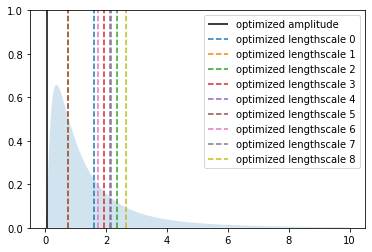

In [ ]:
#@title Visualize MLE versus prior
# visualize lognormal(0, 1), since all hyperparameters have the same prior.
x = np.linspace(0, 10, 1000)
lognormal = tfd.LogNormal(0, 1)
pdf = lognormal.log_prob(x)

plt.fill_between(x, np.exp(pdf), alpha=0.2)
plt.ylim(0, 1)

# Plot the learned values
plt.vlines(
    [amplitude_var._value().numpy()],
    0,
    1,
    label="optimized amplitude",
)

for i in range(num_features):
  plt.vlines(
    [length_scale_var._value().numpy()[i]],
    0,
    1,
    label="optimized lengthscale {}".format(i),
    color="C{}".format(i),
    ls="--"
)



plt.legend()

Most of the learned results look reasonable. The 8th dimension has a much larger lengthscale, implying a milder change in this dimension. The 5th dimension has the smallest lengthscale, indicating the function varies greatly in this dimension.

### Sample from the conditional GP with optimized kernel

With the learned GP, we can sample the conditional GP (conditioned on the training set) at testing points, $X_\mathrm{test}$. The GP is a distribution, so we draw multiple $P_F(k)$ from this conditional GP. And the drawn samples will be our posterior predictions.

In [35]:
# Draw samples from the posterior conditioned on observations

# we will draw samples at the input locations of the test set:
predictive_index_points_ = X_test

# build the GP with maximum likelihood optimized kernel:
optimized_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_var,
)
optimized_kernel = tfk.FeatureScaled(
    optimized_se_kernel, scale_diag = length_scale_var)

# Here we need to use GP Regression model. The tfd.GaussianProcess is only for 
# the likelihood. To make posterior predictions, GaussianProcessRegressionModel
# needs to be used.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,               # learned kernel
    index_points=predictive_index_points_, # testing input points
    observation_index_points=X,            # training input
    observations=Y,                        # training output
    predictive_noise_variance=0.
)

# Draw  200 independent samples
num_samples = 200
samples = gprm.sample(num_samples)

In [36]:
# the drawn samples in the shape of
#   (number of samples, number of outputs, number of test examples)
samples.shape

TensorShape([200, 25, 10])

Text(0, 0.5, 'Normalized output')

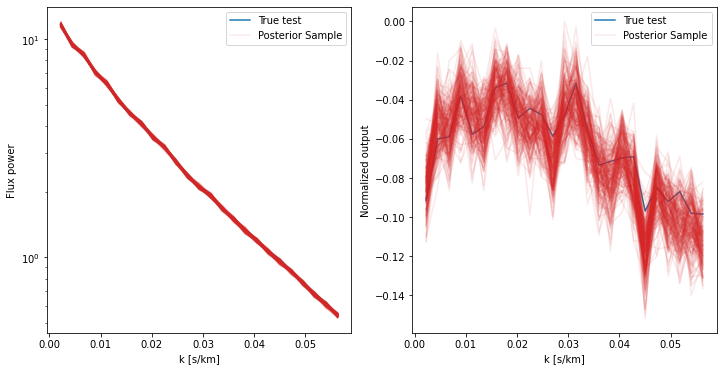

In [37]:
# plot the Pk comparison: GP predictions versus true Pk

#### Changable: Visualize ith simulation ####
test_i = 0 # choose 0 ~ 9
#############################################


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# None-normalized results
ax[0].semilogy(kf, (Y_test[:, test_i] + 1) * scalefactors, label="True test")

for i in range(num_samples):
    ax[0].semilogy(kf, (samples[i, :, test_i] + 1) * scalefactors,
        c='C3', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )
ax[0].legend()
ax[0].set_xlabel(r"k [s/km]")
ax[0].set_ylabel("Flux power")

# Normalized results
ax[1].plot(kf, Y_test[:, test_i], label="True test")

for i in range(num_samples):
    ax[1].plot(kf, samples[i, :, test_i],
        c='C3', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )
ax[1].legend()
ax[1].set_xlabel(r"k [s/km]")
ax[1].set_ylabel("Normalized output")

Let's also plot the test error as a function of k.

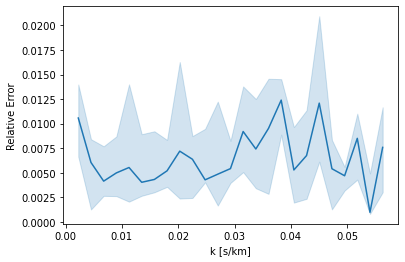

In [38]:
#@title Test error
# Predict / Exact
pred_exact = (samples.numpy().mean(axis=0) + 1) * scalefactors[:, None] / (
    (Y_test + 1) * scalefactors[:, None]
)

# Get the relative errors, which is |Predict / Exact - 1|
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(kf, median_error)
plt.fill_between(
    kf,
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

plt.ylabel("Relative Error")
plt.xlabel(r"k [s/km]")


# save the variable for later use
_pred_exact_map = pred_exact
_samples = samples

Shaded area indicates (25%, 75%) percentiles of the posterior distribution.
Overall, the test error is at $0.5 - 3\%$ level.

## Marginalizing hyperparameters with [Hamiltonian Monte Carlo](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/NoUTurnSampler)

Note: TFP has its own [Markov chain Monte Carlo (MCMC) module](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc), including Hamiltonian Monte Carlo (HMC). The example here is not too different from TFP's [GP with HMC example](https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP#marginalizing_hyperparameters_with_hmc), except we have additional num_outputs and num_features dimensions.

* Why do we care about MCMC here?

 *  **Usually we don't.**  
But in some situations, we want to be fully Bayesian in all modeling steps (i.e., Bayesian obsession). We therefore need to consider the _posterior distributions_ of the hyperparameters. 
Note that here we are not talking about the posterior of predictions or the posterior of cosmologies. Instead, we are talking about **the posteriors of the hyperparameters** (lengthscales and amplitude).

 * **Bayesian model averaging.**  
 Sampling the posterior of the hyperparameters is equivalent to making a Monte Carlo approximation of the model averaging. The maximum likelihood estimate can be viewed as a single model. But many other models can fit the training data. The question is, how do we choose between those models? Model averaging allows us to average over all possible models without selecting one (MLE selects only one model). In this sense, the final functional prediction of your emulator will be a mixture of GPs. For a more in-depth description of this topic, see Roman Garnett's [BayesOpt textbook Chap: 4.4](https://bayesoptbook.com).

---

The maximum likelihood (or maximum a posteriori) estimate is **selecting** a single best model via:
$$
\DeclareMathOperator*{\argmax}{arg\,max}
\hat \theta = \argmax_\theta p(\theta) p(y \mid x, \theta).
$$
Here $\theta$ includes lengthscales and amplitude. $p(\theta)$ is our (multi-dimensional) LogNormal prior.

Model averaging consider averaging the models over $p(\theta \mid \mathcal{D})$, the posterior of hyperparameters. Here, $\mathcal{D}$ is our training set, $\{\boldsymbol{\mathrm{X}}, \boldsymbol{\mathrm{Y}}\}$. The straightforward way is using the Monte Carlo approximation:
$$
\{\theta\}_i^{n_\mathrm{samples}} \sim p(\theta \mid \mathcal{D}).
$$
The posterior predictions from our model averaging could be Monte Carlo approximated as:
$$
p(f \mid \mathcal{D}) \simeq \sum_{i=1}^{n_\mathrm{samples}} \textsf{GaussianProcess}(f; \mu_\mathcal{D}(\theta_i), K_\mathcal{D}(\theta_i)).
$$
Here
$\mu_\mathcal{D}$ and $K_\mathcal{D}$ are mean and covariance functions conditioned on the observations (i.e., training set).
The function posterior is approximated by a mixture of GPs, corresponding to the Monte Carlo sampled hyperparameters.




In [39]:
# Set up HMC sampler

#### Changable: Remember it takes lots of memory to store a mixture of GPs ####
num_results = 100     # number of HMC samples
num_burnin_steps = 50 # initial burning samples to discard
###############################################################################

# Here we use NoUTurnSampler, an adaptive variant of the Hamiltonian Monte Carlo (HMC)
sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)
    ),
    bijector=[constrain_positive, constrain_positive]
)
# Dual averaging policy: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/DualAveragingStepSizeAdaptation
adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    # number of initial steps to during which to adjust the step size
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    # desired acceptance probability
    target_accept_prob=tf.cast(0.75, tf.float64)
)

# initial values for the MCMC
initial_state = [
    tf.cast(1.0, tf.float64),
    tf.cast([1.0 for i in range(9)], tf.float64),
]

Below, we do the Monte Carlo sampling of the hyperparameter posterior:
$$
\{\theta\}_i^{n_\mathrm{samples}} \sim p(\theta \mid \mathcal{D})
$$


In [40]:
# TFP: Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results
  )

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 8.27s.


`samples` is our $\{\theta\}_i^{n_\mathrm{samples}}$, including both lengthscales and amplitude:

$$
\{\theta\}_i^{n_\mathrm{samples}} = \{ \lambda_i, \sigma^2_i \}_i^{n_\mathrm{samples}}
$$

In [41]:
(amplitude_samples, length_scale_samples) = samples

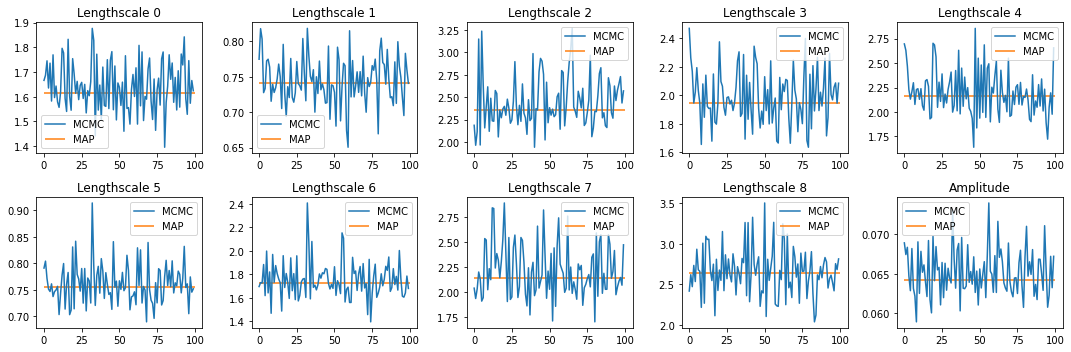

In [42]:
#@title Check the MCMC samples
# check some of the chains

fig, ax = plt.subplots(2, 5, figsize=(15, 5))

for j in range(0, num_features):

    if j < 5: i = 0
    else: i = 1

    ax[i, j - i * 5].set_title("Lengthscale {}".format(j))
    ax[i, j - i * 5].plot(length_scale_samples[:, j], label="MCMC")
    ax[i, j - i * 5].hlines(length_scale_var.numpy()[j], 0, num_results, colors="C1", label="MAP")
    ax[i, j - i * 5].legend()

ax[-1, -1].set_title("Amplitude")
ax[-1, -1].plot(amplitude_samples, label="MCMC")
ax[-1, -1].hlines(amplitude_var.numpy(), 0, num_results, colors="C1", label="MAP")
ax[-1, -1].legend()

fig.tight_layout()

Above we plot 10 * 100 hyperparameters. Each MCMC sample in the plot is a model. We therefore have a mixture of 100 GPs.

Below we visualize how the hyperparameter priors shifted to the posteriors.

For convenience, we normalize the probability density by its maximum value.

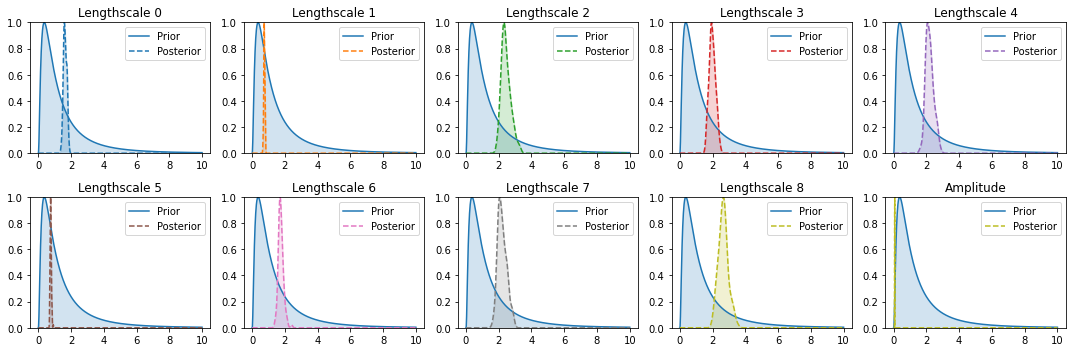

In [43]:
#@title Hyperparameter posterior versus prior
# visualize lognormal(0, 1) prior, and how this prior changed to posterior.
x = np.linspace(0, 10, 1000)
lognormal = tfd.LogNormal(0, 1)
pdf = lognormal.log_prob(x)


# Plot all posteriors
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for j in range(9):

  if j < 5: i = 0
  else: i = 1

  # Since we only have 100 MC samples, we use KDE to approximate the true
  # distribution using the MC samples.
  kde_kernel  = stats.gaussian_kde(length_scale_samples.numpy()[:, j])
  kde_pdf     = kde_kernel(x)

  # Prior
  ax[i, j - i * 5].plot(x, np.exp(pdf) / np.exp(pdf).max(), label="Prior")
  ax[i, j - i * 5].fill_between(x, np.exp(pdf) / np.exp(pdf).max(), alpha=0.2)

  # Plot the learned values
  ax[i, j - i * 5].plot(x, kde_pdf / np.max(kde_pdf), color="C{}".format(j), ls="--", label="Posterior")
  ax[i, j - i * 5].fill_between(x, kde_pdf / np.max(kde_pdf), alpha=0.2, color="C{}".format(j))

  ax[i, j - i * 5].set_ylim(0, 1)

  ax[i, j - i * 5].set_title("Lengthscale {}".format(j))
  ax[i, j - i * 5].legend()


kde_kernel  = stats.gaussian_kde(amplitude_samples.numpy())
kde_pdf     = kde_kernel(x)

# Prior
ax[-1, -1].plot(x, np.exp(pdf) / np.exp(pdf).max(), label="Prior")
ax[-1, -1].fill_between(x, np.exp(pdf) / np.exp(pdf).max(), alpha=0.2)

# Plot the learned values
ax[-1, -1].plot(x, kde_pdf / np.max(kde_pdf), color="C{}".format(j), ls="--", label="Posterior")
ax[-1, -1].fill_between(x, kde_pdf / np.max(kde_pdf), alpha=0.2, color="C{}".format(j))

ax[-1, -1].set_ylim(0, 1)

ax[-1, -1].set_title("Amplitude")
ax[-1, -1].legend()

fig.tight_layout()

### Sample from a mixture of GPs

We can then sample from this mixture of GPs:

$$
p(f \mid \mathcal{D}) \simeq \sum_{i=1}^{n_\mathrm{samples}} \textsf{GaussianProcess}(f; \mu_\mathcal{D}(\theta_i), K_\mathcal{D}(\theta_i))
$$

In [44]:
# The batch dimension now is number of MC samples. So we need to force the TFP
# to realize we have another dimension of num_outputs for k bins. Note again
# this is because we assume all k bins (outputs) shared the same set of hyerparameters.

# now the dimension is (num_results, num_outputs).
batch_of_posterior_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_samples[:, None] * np.ones([num_outputs])[None, :],
)
# dimension for lengthscales: (num_results, num_outputs, num_features).
batch_of_posterior_kernels = tfk.FeatureScaled(
    batch_of_posterior_se_kernel,
    scale_diag = 
      (tf.reshape(
          length_scale_samples,
          [num_results, 1, num_features]) * np.ones([num_outputs])[None, :, None]
      )
  )

# Test input cosmologies
predictive_index_points_ = X_test

# create a batch of GPs (batch is the dimension of num_results)
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=X,
    observations=Y,
    predictive_noise_variance=0.
)

# Model average with uniform weight over the More Carlo samples
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        logits=tf.zeros([num_results])
    ),
    # bacause have an additional dimension of num_outputs
    components_distribution=tfd.Independent(
        batch_gprm, reinterpreted_batch_ndims=1),
  )

In [45]:
# Make sure we did not mess up the shape:
#  batch shape is (100, 25), that is we have (100, 25) GPs. 25 is the num_outputs.
#  Note that num_outputs GPs have the same hyperparameters.
#  event shape is num_exmaples, which is len(X_test) = 10 simulations.
batch_gprm

<tfp.distributions.GaussianProcessRegressionModel 'GaussianProcessRegressionModel' batch_shape=[100, 25] event_shape=[10] dtype=float64>

In [46]:
# Here we make 200 samples from this mixutre of 100 GPs
num_samples = 200
samples = predictive_gprm.sample(num_samples)

In [47]:
# Shape: [num_samples, num_outputs, num_examples]
samples.shape

TensorShape([200, 25, 10])

Text(0, 0.5, 'Normalized output')

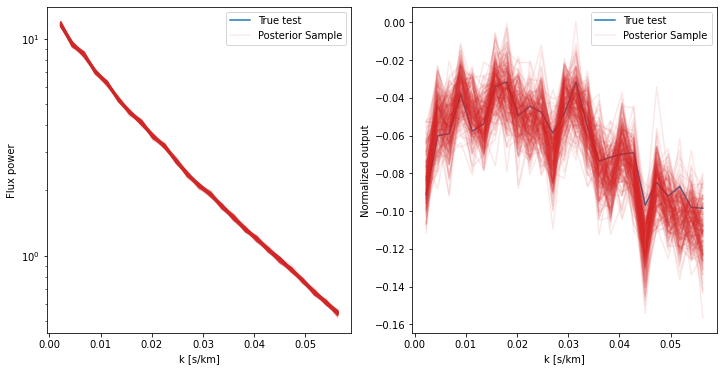

In [48]:
# plot the Pk comparison: GP predictions versus true Pk

#### Changable: Visualize ith simulation ####
test_i = 0 # choose 0 ~ 9
#############################################


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# None-normalized results
ax[0].semilogy(kf, (Y_test[:, test_i] + 1) * scalefactors, label="True test")

for i in range(num_samples):
    ax[0].semilogy(kf, (samples[i, :, test_i] + 1) * scalefactors,
        c='C3', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )
ax[0].legend()
ax[0].set_xlabel(r"k [s/km]")
ax[0].set_ylabel("Flux power")

# Normalized results
ax[1].plot(kf, Y_test[:, test_i], label="True test")

for i in range(num_samples):
    ax[1].plot(kf, samples[i, :, test_i],
        c='C3', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )
ax[1].legend()
ax[1].set_xlabel(r"k [s/km]")
ax[1].set_ylabel("Normalized output")

Let's see if the uncertainty quantification between MLE and HMC is different.

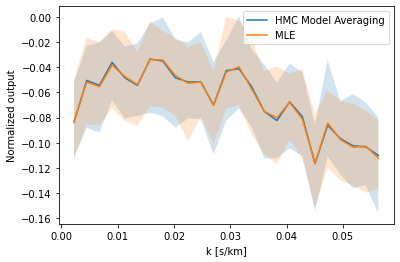

In [49]:
#@title Uncertainty Quantification: MLE versus HMC
hmc_lower, hmc_median, hmc_upper =  np.quantile(samples[:, :, test_i], [0.0, 0.5, 1.0], axis=0)

plt.plot(kf, hmc_median, label="HMC Model Averaging")
plt.fill_between(kf, hmc_lower, hmc_upper, alpha=0.2)

# Overplot the MLE results
mle_lower, mle_median, mle_upper =  np.quantile(_samples[:, :, test_i], [0.0, 0.5, 1.0], axis=0)

plt.plot(kf, mle_median, label="MLE")
plt.fill_between(kf, mle_lower, mle_upper, alpha=0.2)

plt.xlabel(r"k [s/km]")
plt.ylabel("Normalized output")
plt.legend()

Not too different. Probably because the posterior distributions of hyperparameters are highly peaked. So model averaging does not introduce more uncertainty.

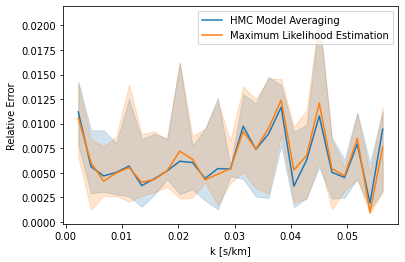

In [50]:
#@title Test errors: MLE versus HMC
# Predict / Exact
pred_exact = (samples.numpy().mean(axis=0) + 1) * scalefactors[:, None] / (
    (Y_test + 1) * scalefactors[:, None]
)

# Get the relative errors, which is |Predict / Exact - 1|
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(kf, median_error, label="HMC Model Averaging")
plt.fill_between(
    kf,
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

plt.ylabel("Relative Error")
plt.xlabel(r"k [s/km]")

# Overplot the maximum likelihood estimate
lower_error, median_error, upper_error = np.quantile(np.abs(_pred_exact_map - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(kf, median_error, color="C1", label="Maximum Likelihood Estimation")
plt.fill_between(
    kf,
    y1=lower_error,
    y2=upper_error,
    color="C1",
    alpha=0.2
)

plt.legend()

The test errors also look very similar.

Some exercises:

1. Change the choice kernel. Do the GP predictions change?
2. Change the number of training points. What's the minimum number of training samples to make the emulation work?
3. What are the other situations you think emulation will be useful?

